# Convergence rates (2D Poisson equation)

In this notebook we numerically verify the theoretical converge rates of the finite element discretization of an elliptic problem.

Specifically, for a domain $\Omega \subset \mathbb{R}^2$ with boundary $\partial \Omega = \Gamma_D \cup \Gamma_N$, we consider the  the boundary value problem (BVP):

$$ 
\left\{
\begin{array}{ll}
- \Delta u = f  & \text{in} \; \Omega, \\
u = u_D & \text{on} \; \Gamma_D, \\
\nabla u \cdot \boldsymbol{n} = g & \text{on} \; \Gamma_N.
\end{array}
\right.$$

Here, $\Gamma_D \subset \Omega$ denotes the part of the boundary where we prescribe Dirichlet boundary conditions, and $\Gamma_N \subset \Omega$ denotes the part of the boundary where we prescribe Neumann boundary conditions. $\boldsymbol{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$. 

The coefficient $f$, $g$, $u_D$ are chosen such that the analytical solution is $u_{ex} = e^{\pi y} \sin(\pi x)$.

To obtain the weak form, we define the functional spaces $V_{u_D} = \{ v \in H^1(\Omega) \, |\, v = u_D \text{ on } \Gamma_D\}$ and $V_{0} = \{ v \in H^1(\Omega) \,| \, v = 0 \text{ on } \Gamma_D\}$.

Then, the weak formulation of the boundary value problem reads

Find $u \in V_{u_D}$:
$$ \int_\Omega \nabla u \cdot \nabla v \, dx = \int_\Omega f\,v \, dx + \int_{\Gamma_N} g\,v\,ds, \quad \forall v \in V_0. $$

Finally, to obtain the finite element discretization we introduce a uniform triangulation (mesh) $\mathcal{T}_h$ of the domain $\Omega$ and finite dimensional subspace $V_h \subset H^1(\Omega)$. 
The space $V_{h}$ consists of globally continuous functions that are piecewise polynomial with degree $k$ on each element $\tau$ of the mesh $\mathcal{T}_h$, that is
$$ V_h := \left\{ v_h \in V \; | \; \left. v_h \right|_{\tau} \in P^{k} \quad  \forall \tau \in \mathcal{T}_h \right\},$$
where $P^{k}$ denotes the space of polynomial function with degree $k$.

By letting $V_{h, u_D} := \{ v_h \in V_h \, | \, v_h = u_D \text{ on } \Gamma_D\}$ and $V_{h, 0} := \{ v_h \in V_h \, | \, v_h = 0 \text{ on } \Gamma_D\}$, the finite element discretization of the BVP reads:

Find $u_h \in V_{h, u_D}$ such that
$$ \int_\Omega \nabla u_h \cdot \nabla v_h \, dx = \int_\Omega f\,v_h \, dx + \int_{\Gamma_N} g\,v_h\,ds, \quad \forall v_h \in V_{h,0}. $$

## Finite element error estimates

Assuming that the analytical solution is regular enough (i.e. $u_{\rm ex} \in H^{k+1}(\Omega)$), the following error estimates hold

- Energy norm:
$$ \left\| u_{\rm ex} - u_h \right\|_{\rm energy} := \left( \int_\Omega \left| \nabla u_{\rm ex} - \nabla u_{h}\right|^2 dx \right)^{\frac{1}{2}} = \mathcal{O}(h^k), $$

- $L^2(\Omega)$ norm:
$$ \left\| u_{\rm ex} - u_h \right\|_{L^2} := \left( \int_\Omega \left|u_{\rm ex} - u_{h}\right|^2 dx \right)^{\frac{1}{2}} = \mathcal{O}(h^{k+1}), $$

where $h$ denote the mesh size.

## Step 1. Import modules

In [1]:
# Import FEniCSx
import dolfinx as dl
import ufl

from mpi4py import MPI
from petsc4py import PETSc

# Import the package of mathematical functions
import math
import numpy as np
# Enable plotting inside the notebook
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('static')

## Step 2. Finite element solution of the BVP

Here we implement a function `solveBVP` that computes the finite element discretizions and solves the discretized problem.

As input, it takes the number of mesh elements `n` in each direction and the polynomial degree `degree` of the finite element space. As output, it returns the errors in the $L^2$ and energy norm.

In [2]:
def solveBVP(n, degree):
    comm = MPI.COMM_WORLD

    # Define the finite element mesh. The mesh size h is 1/nx
    
    mesh = dl.mesh.create_unit_square(comm, n, n, dl.mesh.CellType.triangle)
    cells, types, coords = dl.plot.create_vtk_mesh(mesh, mesh.topology.dim)
    grid = pv.UnstructuredGrid(cells, types, coords)

    # Define the finite element space V_h as the space of piecewise linear functions on the elements of the mesh.
    Vh = dl.fem.FunctionSpace(mesh, ("CG", degree))
    Vhp = dl.fem.FunctionSpace(mesh, ("CG", degree+2))
    u  = dl.fem.Function(Vh)

    u_bc = dl.fem.Function(Vh)
    u_bc.interpolate(lambda x: np.exp(np.pi * x[1]) *np.sin(np.pi * x[0]))



    facet_dim = mesh.topology.dim-1
    facets_D = dl.mesh.locate_entities_boundary(mesh, dim=facet_dim, \
                                        marker=lambda x: np.logical_or(np.isclose(x[0], 0.0), \
                                        np.logical_or(np.isclose(x[1], 0.0), np.isclose(x[0], 1.0))))
    dofs_D = dl.fem.locate_dofs_topological(V=Vh, entity_dim=facet_dim, entities=facets_D)


    bcs = [dl.fem.dirichletbc(u_bc, dofs_D)]

    
    uh = ufl.TrialFunction(Vh)
    vh = ufl.TestFunction(Vh)

    f = dl.fem.Constant(mesh, PETSc.ScalarType(0.))
    g = dl.fem.Function(Vhp)
    g.interpolate(lambda x: np.pi * np.exp(np.pi*x[1])* np.sin(np.pi*x[0]))
    
    A_expr = ufl.inner(ufl.grad(uh), ufl.grad(vh)) * ufl.dx
    b_expr = f * vh * ufl.dx + g * vh * ufl.ds

    problem = dl.fem.petsc.LinearProblem(A_expr, b_expr, u=u, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    problem.solve()

    
    
    u_ex = dl.fem.Function(Vhp)
    u_ex.interpolate(lambda x: np.exp(np.pi*x[1]) * np.sin(np.pi*x[0]))
    
    loc_err_L2 = dl.fem.assemble_scalar(dl.fem.form((u_ex-u)**2 * ufl.dx))
    err_L2  = np.sqrt(mesh.comm.allreduce(loc_err_L2, op=MPI.SUM))

    loc_err_energy = dl.fem.assemble_scalar(dl.fem.form(ufl.inner(ufl.grad(u) - ufl.grad(u_ex), ufl.grad(u) - ufl.grad(u_ex)) * ufl.dx))
    err_energy = np.sqrt(mesh.comm.allreduce(loc_err_energy, op=MPI.SUM))
    
    return err_L2, err_energy

## Step 3. Generate the converges plots

The function `make_convergence_plot` generates the converges plots.

It takes as input a `numpy.array` that contains a sequence of number of mesh elements and the polynomial degree `degree` of the finite element space.

It plots the energy norm of the error (in red) and the $L^2$ norm of the error (in blue) in a loglog scale. The $x$-axis is the mesh size $h$.

The slope of the lines in the loglog scale represents the order of converge and dotted lines represents the expected convergence rate.

In [3]:
def make_convergence_plot(n, degree):
    errs_L2 = np.zeros(n.shape)
    errs_En = np.zeros(n.shape)
    
    for i in np.arange(n.shape[0]):
        print(i, ": Solving problem on a mesh with", n[i], " elements.")
        eL2, eE = solveBVP(n[i], degree)
        errs_L2[i] = eL2
        errs_En[i] = eE
        
    h = np.ones(n.shape)/n
    plt.loglog(h, errs_L2, '-*b', label=r'$L^{2}$')
    plt.loglog(h, errs_En, '-*r', label='Energy')
    plt.loglog(h, .7*np.power(h,degree+1)*errs_L2[0]/np.power(h[0],degree+1), '--b', label = 'order {0}'.format(degree+1))
    plt.loglog(h, .7*np.power(h,degree)*errs_En[0]/np.power(h[0],degree), '--r', label = 'order {0}'.format(degree))
    plt.legend()
    plt.grid()
    plt.xlabel(r'$h$')
    plt.ylabel('numerical solution error')
    plt.show()
    

## Converges rate of piecewise linear finite element ($k=1$)

0 : Solving problem on a mesh with 4  elements.
1 : Solving problem on a mesh with 8  elements.
2 : Solving problem on a mesh with 16  elements.
3 : Solving problem on a mesh with 32  elements.
4 : Solving problem on a mesh with 64  elements.


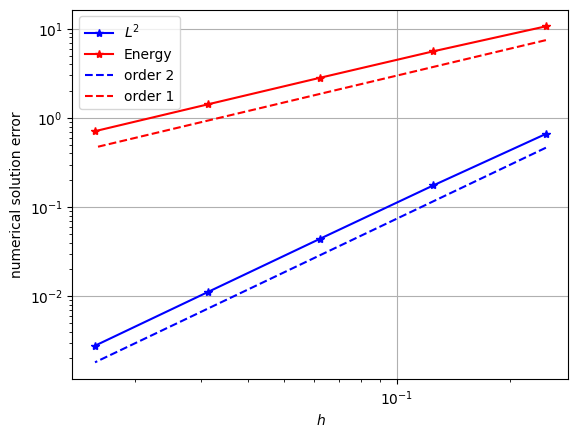

In [4]:
degree = 1
n = np.power(2, np.arange(2,7)) # n = [2^2, 2^3, 2^4 2^5, 2^6]
make_convergence_plot(n, degree)

## Converges rate of piecewise quadratic finite element ($k=2$)

0 : Solving problem on a mesh with 4  elements.
1 : Solving problem on a mesh with 8  elements.
2 : Solving problem on a mesh with 16  elements.
3 : Solving problem on a mesh with 32  elements.
4 : Solving problem on a mesh with 64  elements.


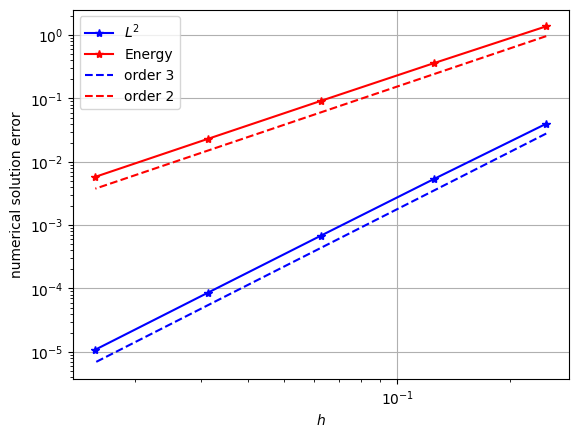

In [5]:
degree = 2
make_convergence_plot(n, degree)